# Classification de Postures par Fusion d’Images et de Points Clés avec ResNet50 & MoveNet

Ce notebook présente un pipeline complet pour la classification d’images selon la posture, en combinant les caractéristiques extraites par un modèle ResNet50 et les points clés du corps détectés par MoveNet.

**Exemple d'application : ce notebook est utilisé pour la classification automatique des postures lors des gestes de dépistage du cancer du sein.**

## Objectifs

- Classifier des images selon différentes postures ou positions corporelles.
- Utiliser à la fois les informations visuelles (features extraites par ResNet50) et les points clés du squelette humain (keypoints MoveNet) pour améliorer la robustesse de la classification.
- Évaluer les performances du modèle sur des jeux de données réels.

## Pipeline du notebook

1. **Montage de Google Drive**
   - Accès aux datasets et sauvegarde des modèles.

2. **Installation et import des dépendances**
   - TensorFlow, TensorFlow Hub, OpenCV, scikit-learn, matplotlib, seaborn, etc.

3. **Préparation des données**
   - Chargement des images organisées par classe.
   - Détection automatique des points clés (keypoints) sur chaque image avec MoveNet.
   - Prétraitement des images et création des labels.

4. **Construction du modèle**
   - Extraction des features visuelles avec ResNet50 (pré-entraîné ImageNet).
   - Fusion des features ResNet et des keypoints dans un réseau de neurones dense.
   - Entraînement du modèle sur les images et les keypoints.

5. **Évaluation**
   - Séparation des données en train/validation/test.
   - Calcul des métriques (accuracy, précision, rappel, matrice de confusion).
   - Visualisation des courbes de perte et de la matrice de confusion.

6. **Prédiction et test**
   - Prédiction de la classe d’une nouvelle image.
   - Test du modèle sur un dossier d’images.

7. **Gestion mémoire**
   - Libération de la mémoire GPU/CPU après l’entraînement.

## Applications

- Détection automatique de postures pour le sport, la santé, la rééducation, la sécurité, etc.
- Analyse de mouvements humains à partir d’images ou de vidéos.

---

> Ce notebook démontre comment combiner efficacement vision par ordinateur et analyse de pose pour améliorer la classification d’images de postures.

In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow tensorflow-hub opencv-python numpy scikit-learn matplotlib seaborn keras-applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 761.2 kB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and set to memory growth mode")
else:
    print("No GPU found, using CPU")

model_movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model_movenet.signatures['serving_default']

def detect_keypoints(image):
    input_image = tf.image.resize(image, (256, 256))
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints[0][0]

def load_and_process_images(base_path):
    images = []
    keypoints_list = []
    labels = []
    class_names = sorted(os.listdir(base_path))

    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        label = class_names.index(class_name)

        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(class_path, filename)
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                keypoints = detect_keypoints(image_rgb)
                keypoints_list.append(keypoints)

                image_rgb = cv2.resize(image_rgb, (224, 224))
                image_rgb = preprocess_input(image_rgb)
                images.append(image_rgb)
                labels.append(label)

    return np.array(images), np.array(keypoints_list), np.array(labels), class_names

train_base_path = '/content/drive/MyDrive/Master 2/dataset_aug/train'
test_base_path = '/content/drive/MyDrive/Master 2/dataset_aug/test'

X_train_images, X_train_keypoints, y_train, class_names = load_and_process_images(train_base_path)
X_test_images, X_test_keypoints, y_test, _ = load_and_process_images(test_base_path)

X_train_images, X_val_images, X_train_keypoints, X_val_keypoints, y_train, y_val = train_test_split(
    X_train_images, X_train_keypoints, y_train, test_size=0.15, random_state=42
)

GPU is available and set to memory growth mode


Epoch 1/15
15/15 [==============================] - 57s 1s/step - loss: 1.3450 - accuracy: 0.4175 - val_loss: 0.6528 - val_accuracy: 0.8699
Epoch 2/15
15/15 [==============================] - 8s 505ms/step - loss: 0.4640 - accuracy: 0.8594 - val_loss: 0.2372 - val_accuracy: 0.9268
Epoch 3/15
15/15 [==============================] - 8s 509ms/step - loss: 0.1182 - accuracy: 0.9742 - val_loss: 0.0252 - val_accuracy: 0.9919
Epoch 4/15
15/15 [==============================] - 8s 505ms/step - loss: 0.0349 - accuracy: 0.9914 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/15
15/15 [==============================] - 8s 506ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 5.0647e-04 - val_accuracy: 1.0000
Epoch 6/15
15/15 [==============================] - 8s 534ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.7569e-04 - val_accuracy: 1.0000
Epoch 7/15
15/15 [==============================] - 8s 523ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.9203e-04 - val_accuracy: 1.0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 6s 206ms/step - loss: 0.2977 - accuracy: 0.8939
Accuracy: 0.8939393758773804
9/9 [==============================] - 2s 94ms/step
Confusion Matrix:
[[55  5  1  5]
 [ 1 52  3 10]
 [ 2  0 57  1]
 [ 0  0  0 72]]
Accuracy: 0.8939393939393939
Precision: 0.9006492344391057
Recall: 0.8939393939393939


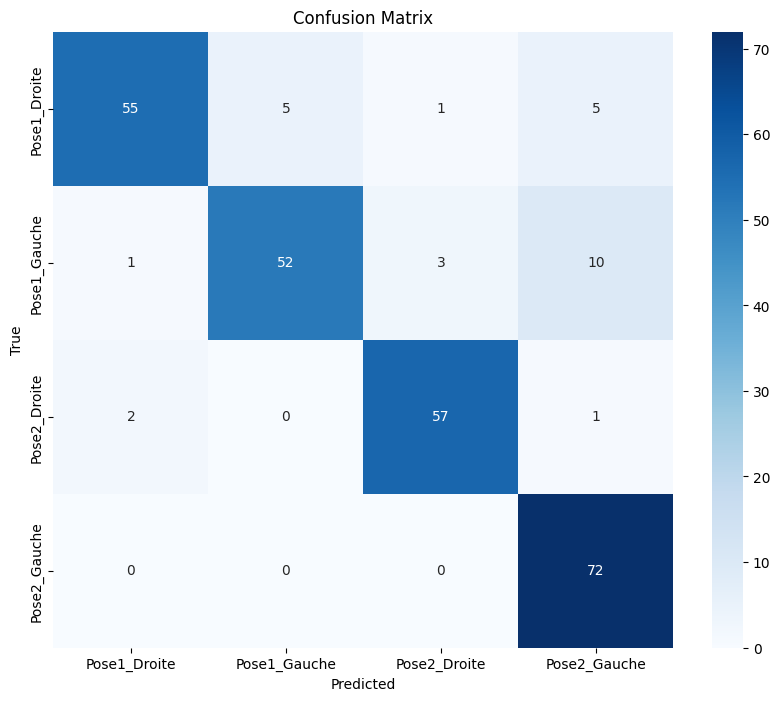

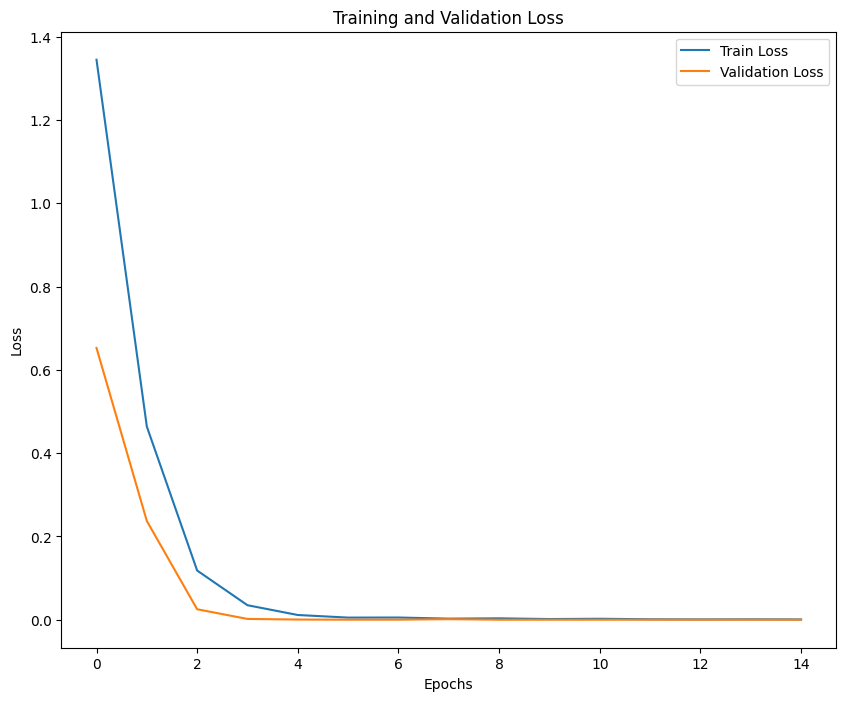

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

keypoints_input = Input(shape=(17, 3))
flattened_keypoints = Flatten()(keypoints_input)

combined = Concatenate()([x, flattened_keypoints])

combined = Dense(1024, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined = Dense(512, activation='relu')(combined)
combined = Dropout(0.5)(combined)
predictions = Dense(len(class_names), activation='softmax')(combined)

model = Model(inputs=[base_model.input, keypoints_input], outputs=predictions)

for layer in base_model.layers[-15:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_train_images, X_train_keypoints], y_train,
    epochs=15, batch_size=48,
    validation_data=([X_val_images, X_val_keypoints], y_val)
)

model.save('/content/drive/MyDrive/Master 2/pose_classification_model_resnet_with_keypoints_V1.h5')

loaded_model = load_model('/content/drive/MyDrive/Master 2/pose_classification_model_resnet_with_keypoints_V1.h5')

loss, accuracy = loaded_model.evaluate([X_test_images, X_test_keypoints], y_test)
print(f'Accuracy: {accuracy}')

y_pred = loaded_model.predict([X_test_images, X_test_keypoints])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from keras import backend as K

def clear_memory():
    try:
        del model
        del X_train, y_train, X_test, y_test, X_val_images, X_val_keypoints
        print("Variables removed successfully.")
    except NameError as e:
        print(f"Error removing variables: {e}")

    K.clear_session()

    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

    tf.compat.v1.reset_default_graph()

    print("TensorFlow session cleared.")

clear_memory()


Error removing variables: local variable 'model' referenced before assignment
TensorFlow session cleared.


In [ ]:

def predict_class(image_path, model, class_names, threshold=0.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    keypoints = detect_keypoints(image_rgb)
    keypoints = np.expand_dims(keypoints, axis=0)

    image_rgb = cv2.resize(image_rgb, (224, 224))
    image_rgb = preprocess_input(image_rgb)
    image_rgb = np.expand_dims(image_rgb, axis=0)

    predictions = model.predict([image_rgb, keypoints])
    max_confidence = np.max(predictions)
    class_index = np.argmax(predictions)

    if max_confidence < threshold:
        return "Pose incorrecte", max_confidence
    else:
        return class_names[class_index], max_confidence

test_image_path = 'test2.jpg'
predicted_class, confidence = predict_class(test_image_path, loaded_model, class_names)
print(f'The predicted class is: {predicted_class} with confidence: {confidence}')

def test_model_on_images(test_images_path, model, class_names):
    for filename in os.listdir(test_images_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(test_images_path, filename)
            predicted_class, confidence = predict_class(image_path, model, class_names)
            print(f'The predicted class for {filename} is: {predicted_class} with confidence: {confidence}')

test_images_path = 'test_images'

test_model_on_images(test_images_path, loaded_model, class_names)


In [ ]:
import time
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and set to memory growth mode")
else:
    print("No GPU found, using CPU")

model_movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model_movenet.signatures['serving_default']

def detect_keypoints(image):
    input_image = tf.image.resize(image, (256, 256))
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints[0][0]

def load_and_process_images(base_path):
    images = []
    keypoints_list = []
    labels = []
    class_names = sorted(os.listdir(base_path))

    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        label = class_names.index(class_name)

        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(class_path, filename)
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                keypoints = detect_keypoints(image_rgb)
                keypoints_list.append(keypoints)

                image_rgb = cv2.resize(image_rgb, (224, 224))
                image_rgb = preprocess_input(image_rgb)
                images.append(image_rgb)
                labels.append(label)

    return np.array(images), np.array(keypoints_list), np.array(labels), class_names

loaded_model = load_model('/content/drive/MyDrive/Master 2/pose_classification_model_resnet_with_keypoints_V1.h5')

train_base_path = '/content/drive/MyDrive/Master 2/dataset_aug/train'
test_base_path = '/content/drive/MyDrive/Master 2/dataset_aug/test'

X_train_images, X_train_keypoints, y_train, class_names = load_and_process_images(train_base_path)
X_test_images, X_test_keypoints, y_test, _ = load_and_process_images(test_base_path)

X_train_images, X_val_images, X_train_keypoints, X_val_keypoints, y_train, y_val = train_test_split(
    X_train_images, X_train_keypoints, y_train, test_size=0.15, random_state=42
)

loss, accuracy = loaded_model.evaluate([X_test_images, X_test_keypoints], y_test)
print(f'Accuracy: {accuracy}')

single_image = np.expand_dims(X_test_images[0], axis=0)
single_keypoints = np.expand_dims(X_test_keypoints[0], axis=0)
start_time = time.time()
single_pred = loaded_model.predict([single_image, single_keypoints])
end_time = time.time()

single_inference_time = end_time - start_time
print(f'Time taken for inference on a single image: {single_inference_time} seconds')

y_pred = loaded_model.predict([X_test_images, X_test_keypoints])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


GPU is available and set to memory growth mode
9/9 [==============================] - 5s 196ms/step - loss: 0.2977 - accuracy: 0.8939
Accuracy: 0.8939393758773804
1/1 [==============================] - 2s 2s/step
Time taken for inference on a single image: 2.6563868522644043 seconds
9/9 [==============================] - 1s 84ms/step
Confusion Matrix:
[[55  5  1  5]
 [ 1 52  3 10]
 [ 2  0 57  1]
 [ 0  0  0 72]]
Accuracy: 0.8939393939393939
Precision: 0.9006492344391057
Recall: 0.8939393939393939


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
